˙ 모델 투입 전 이미지를 불러오는 방식에 npy 파일 형식 활용</br>
해당 파일은 npy를 save하는 방식은 다루고 있지 않습니다
=> FYI :: 이미지를 불러오는 방식에 flow_from_directory라는 다른 메소드도 있는데요, 이 방법의 경우 폴더 형태의 데이터 구조를 바로 가져와서 사용할 수 있다는 장점이 있습니다만 이미지 데이터 동기화의 효율성이 너무 떨어져서 배제하겠습니다.

In [0]:
%tensorflow_version 1.x

In [0]:
# 1. 모듈 import
import os, numpy as np
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
# 2. npy 데이터를 불러와서 모델 학습
X_train, X_test, y_train, y_test = np.load("/content/drive/My Drive/test_data_after.npy", allow_pickle=True)
print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')  
print(f'X_test: {X_test.shape}, y_train: {y_test.shape}') 


X_train: (15916, 64, 64, 3), y_train: (15916, 5)
X_test: (3980, 64, 64, 3), y_train: (3980, 5)


In [0]:
# 3. 정규화
X_train = X_train.astype(float) / 255
X_test = X_test.astype(float) / 255

In [17]:
# 4. 검증 세트(val set) 준비 (X_train의 20%, 3183개를 따로 분리)
X_val = X_train[:3183]
X_train = X_train[3183:]
y_val = y_train[:3183]
y_train = y_train[3183:]
print(f'X_val : {X_val.shape}, X_train : {X_train.shape}')
print(f'y_val : {y_val.shape}, y_train : {y_train.shape}')


X_val : (3183, 64, 64, 3), X_train : (9550, 64, 64, 3)
y_val : (3183, 5), y_train : (9550, 5)
[0 0 0 0 1]


In [83]:
# 4. CNN 모델 구성
model = Sequential()
model.add(Conv2D(32, kernel_size=(4, 4), strides=(1, 1), padding='same', activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 64, 64, 32)        1568      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 8, 8, 64)         

In [0]:
# 4. 모델 컴파일
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [86]:
# 5. 모델 학습
model_dir = "./model"
if not os.path.exists(model_dir):
  os.mkdir(model_dir)
model_path = model_dir + '/test.model'
checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
hist = model.fit(X_train, y_train, epochs=150, batch_size=100, validation_data=(X_val, y_val), callbacks=[checkpoint, early_stopping])


Train on 9550 samples, validate on 3183 samples
Epoch 1/150
9550/9550 [==============================] - 3s 305us/step - loss: 1.6086 - acc: 0.2150 - val_loss: 1.6066 - val_acc: 0.2092

Epoch 00001: val_loss improved from inf to 1.60661, saving model to ./model/test.model
Epoch 2/150
9550/9550 [==============================] - 2s 243us/step - loss: 1.6075 - acc: 0.2159 - val_loss: 1.5944 - val_acc: 0.2746

Epoch 00002: val_loss improved from 1.60661 to 1.59442, saving model to ./model/test.model
Epoch 3/150
9550/9550 [==============================] - 2s 244us/step - loss: 1.5151 - acc: 0.3231 - val_loss: 1.4237 - val_acc: 0.3393

Epoch 00003: val_loss improved from 1.59442 to 1.42365, saving model to ./model/test.model
Epoch 4/150
9550/9550 [==============================] - 2s 243us/step - loss: 1.4172 - acc: 0.3745 - val_loss: 1.6081 - val_acc: 0.2966

Epoch 00004: val_loss did not improve from 1.42365
Epoch 5/150
9550/9550 [==============================] - 2s 242us/step - loss: 1

In [87]:
# 모델 정확도 계산
score = model.evaluate(X_val, y_val, verbose=0)
print('Training loss:', score[0])
print('Training accuracy: ', score[1])

Training loss: 0.5521152452818823
Training accuracy:  0.7829092051898239


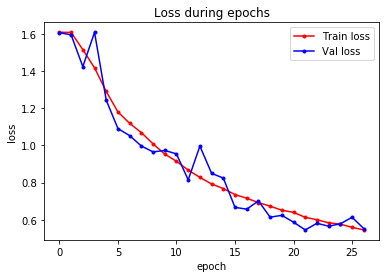

In [88]:
# loss 그래프
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

x = range(len(train_loss))
plt.plot(x, train_loss, marker='.', color='red', label='Train loss')
plt.plot(x, val_loss, marker='.', color='blue', label='Val loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss during epochs')
plt.show()

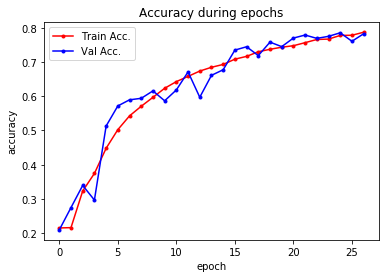

In [89]:
# acc 그래프
train_acc = hist.history['acc']
val_acc = hist.history['val_acc']

plt.plot(x, train_acc, marker='.', c='red', label='Train Acc.')
plt.plot(x, val_acc, marker='.', c='blue', label='Val Acc.')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy during epochs')
plt.show()
